# Deep Learning on Medicial Computer Vision


# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/5318-assignemnt2
import os
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axis import XAxis
import sklearn
import time
import tensorflow as tf
import albumentations as A
import cv2
import random
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.python.framework import random_seed
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from imgaug import augmenters as iaa



# Data loading, exploration, and preprocessing

## Data loading

In [ ]:
# Load data
seed = 1000
np.random.seed(seed)
tf.random.set_seed(seed)

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (13673, 28, 28, 3)
y_train shape: (13673,)
X_test shape: (3419, 28, 28, 3)
y_test shape: (3419,)


In [ ]:
# number of label
num_label = np.unique(y_train)
print(num_label)

[0 1 2 3 4 5 6 7]


## Data exploration

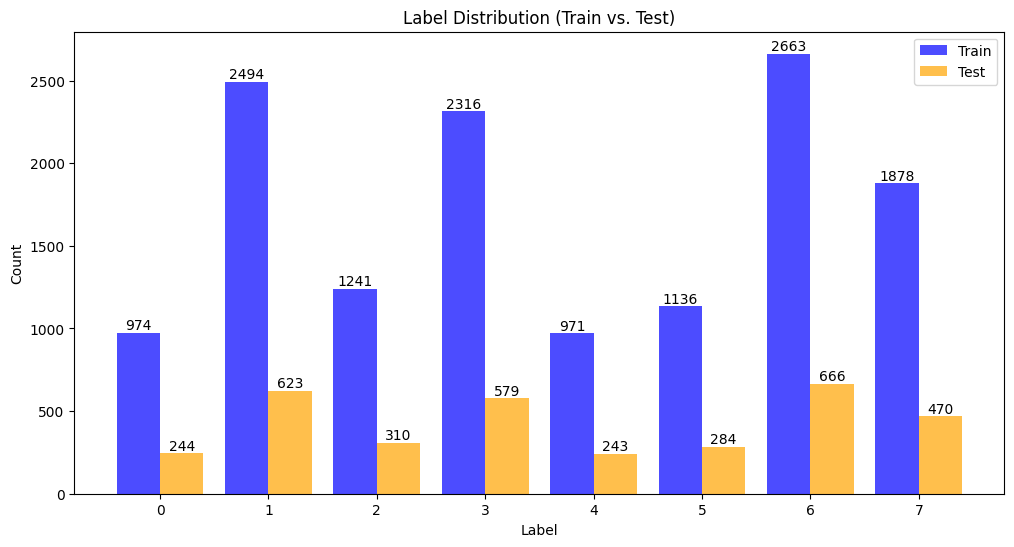

In [ ]:
# Plotting the label distribution of the training set
label_counts_train = np.bincount(y_train)
unique_labels_train = np.unique(y_train)

# Plotting the label distribution of the test set
label_counts_test = np.bincount(y_test)
unique_labels_test = np.unique(y_test)

plt.figure(figsize=(12, 6))
width = 0.4
train_bars = plt.bar(unique_labels_train - width / 2, label_counts_train, width, label='Train', align='center', color='blue', alpha=0.7)
test_bars = plt.bar(unique_labels_test + width / 2, label_counts_test, width, label='Test', align='center', color='orange', alpha=0.7)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution (Train vs. Test)')

# Label each column with the count value
for bars, label_counts in zip([train_bars, test_bars], [label_counts_train, label_counts_test]):
    for bar, count in zip(bars, label_counts):
        plt.text(bar.get_x() + bar.get_width() / 2, count, str(count), ha='center', va='bottom')

plt.xticks(unique_labels_train)
plt.legend()
plt.show()

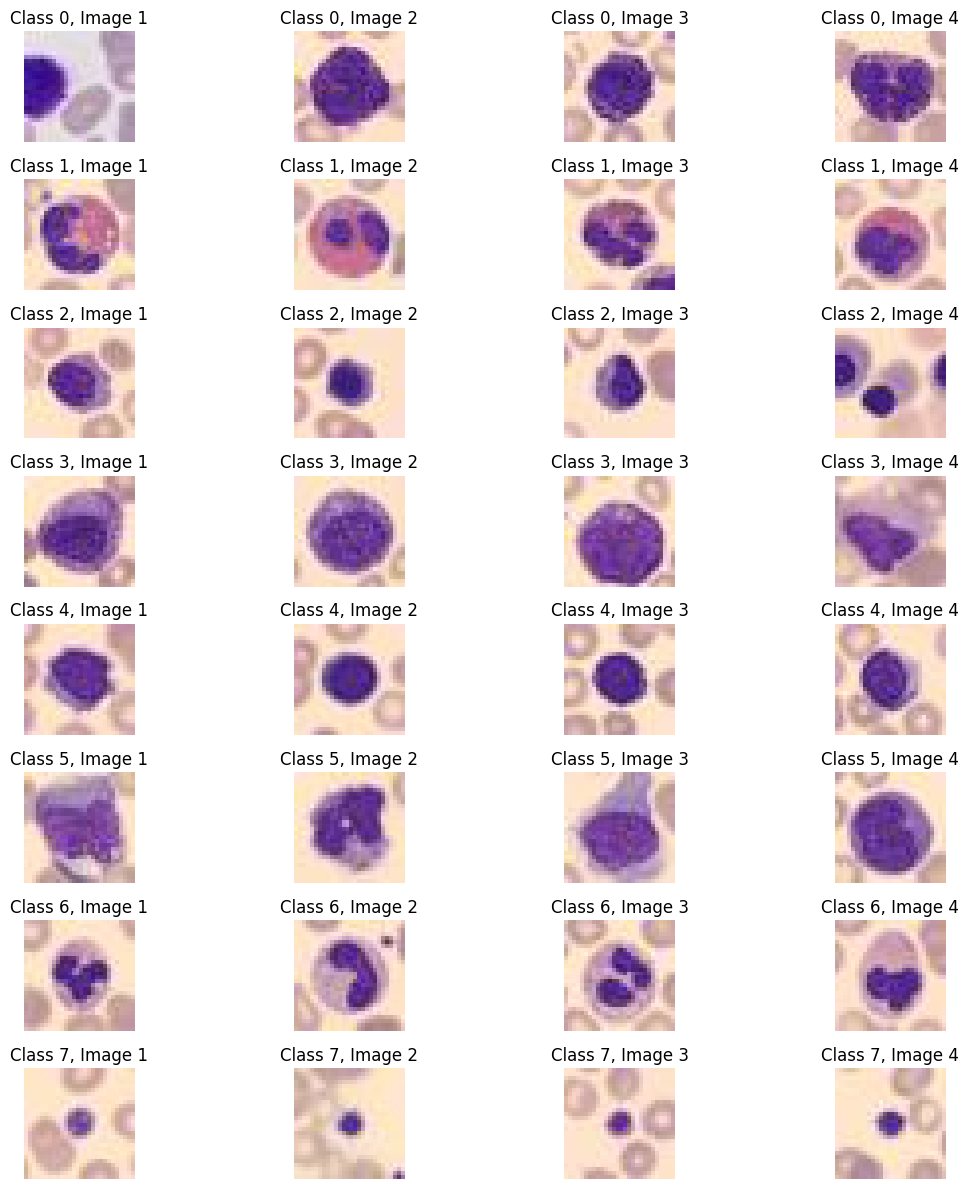

In [ ]:
np.random.seed(42)
# Display 8 categories and 4 images in each category
num_classes = 8
images_per_class = 4

# Create an image grid with 8 rows and 4 columns, each row corresponding to a category
fig, axes = plt.subplots(num_classes, images_per_class, figsize=(12, 12))

# Loop through each category and randomly obtain the indexes of the 4 images in each category
for class_index in range(num_classes):
    class_indices = np.where(y_train == class_index)[0]
    random_indices = np.random.choice(class_indices, images_per_class, replace=False)

    # Loop through each image
    for i in range(images_per_class):
        axes[class_index, i].imshow(X_train[random_indices[i]])
        axes[class_index, i].set_title(f"Class {class_index}, Image {i + 1}")
        axes[class_index, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Initialize the dictionary that stores the results
results = {
    'mean': [],
    'std': [],
    'min': [],
    'max': []
}
image_means = np.mean(X_train, axis=(1, 2))
# Loop through each category
for label in np.unique(y_train):
    class_indices = np.where(y_train == label)[0]
    class_images = image_means[class_indices]
    print(label, class_images.shape)

    # Calculate mean, standard deviation, minimum and maximum values
    class_mean = np.round(np.mean(class_images, axis=0), 3)
    class_std = np.round(np.std(class_images, axis=0), 3)
    class_min = np.round(np.min(class_images, axis=0), 3)
    class_max = np.round(np.max(class_images, axis=0), 3)

    # Storing results
    results['mean'].append(class_mean)
    results['std'].append(class_std)
    results['min'].append(class_min)
    results['max'].append(class_max)

for label, stats in enumerate(results['mean']):
    print(f"Class {label}:")
    print(f"Mean: {results['mean'][label]}")
    print(f"Std: {results['std'][label]}")
    print(f"Min: {results['min'][label]}")
    print(f"Max: {results['max'][label]}")
    print()

0 (974, 3)
1 (2494, 3)
2 (1241, 3)
3 (2316, 3)
4 (971, 3)
5 (1136, 3)
6 (2663, 3)
7 (1878, 3)
Class 0:
Mean: [192.495 156.622 173.43 ]
Std: [ 8.268 10.47   6.271]
Min: [161.302 120.295 152.156]
Max: [214.379 182.833 207.547]

Class 1:
Mean: [200.194 161.15  173.413]
Std: [6.697 8.678 5.459]
Min: [166.689 121.51  156.054]
Max: [217.02  191.577 210.26 ]

Class 2:
Mean: [211.961 182.198 181.715]
Std: [11.424 11.556  6.635]
Min: [152.82  124.286 161.176]
Max: [238.732 209.885 217.911]

Class 3:
Mean: [189.068 154.686 174.86 ]
Std: [13.11  14.515  8.538]
Min: [115.713  76.144 149.548]
Max: [219.219 189.862 215.121]

Class 4:
Mean: [204.938 173.253 178.654]
Std: [6.899 7.643 6.738]
Min: [165.403 134.032 163.973]
Max: [222.546 194.117 215.515]

Class 5:
Mean: [185.557 150.868 175.267]
Std: [7.828 9.069 6.032]
Min: [153.075 109.511 159.276]
Max: [210.259 178.915 209.032]

Class 6:
Mean: [203.813 169.503 177.776]
Std: [7.075 8.493 5.493]
Min: [173.522 128.529 157.764]
Max: [223.557 193.916 214.

## Preprocessing

In [ ]:
X = X_train/255.
X, X_val, y, y_val = train_test_split(X, y_train, test_size=0.2, random_state=42)
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
normalized_X = (X- mean) / std
normalized_X_val = (X_val-mean) / std

In [ ]:
transform_sequence = iaa.Sequential([
                    iaa.Fliplr(0.5),            # flip 1
                    iaa.Flipud(0.5)            # flip 2
                    # iaa.Add((-32, 32))           # brightness
                    # iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))  # Gaussian Noise
                    # iaa.WithColorspace(
                    #     to_colorspace="HSV",
                    #     from_colorspace="RGB",
                    #     children=iaa.WithChannels(      # hue
                    #         0,
                    #         iaa.Add((-18, 18))
                    #     )
                    # )
                    # iaa.WithColorspace(
                    #     to_colorspace="HSV",
                    #     from_colorspace="RGB",
                    #     children=iaa.WithChannels(      # saturation
                    #         1,
                    #         iaa.Multiply((0.5, 1.5))
                    #     )
                    # )
                    # iaa.Multiply((0.5, 1.5))    # contrast
])


## Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

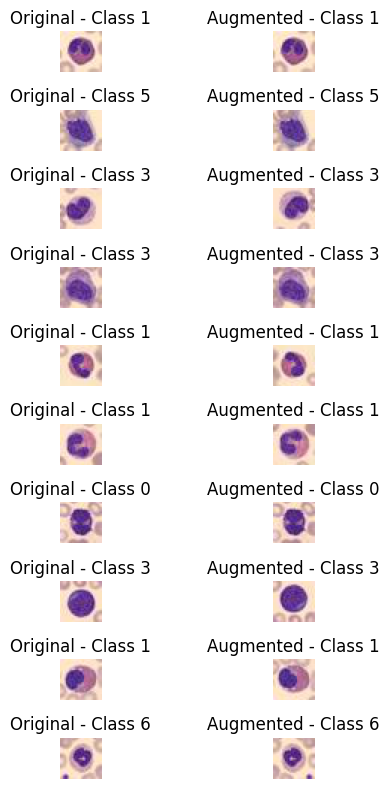

In [ ]:
# Randomly select 10 indexes to get the original image and the augmented image
random_indices = random.sample(range(len(X_train)), 10)

# Create a chart that contains two images per row: the original image and the augmented image
plt.figure(figsize=(6, 8))

for i, idx in enumerate(random_indices):
    original_image = X_train[idx]
    augmented_image = transform_sequence.augment_image(original_image)

    # Plotting the original image
    plt.subplot(10, 2, 2 * i + 1)
    plt.imshow(original_image)
    plt.title(f'Original - Class {y_train[idx]}')
    plt.axis('off')

    # Plotting the augmented image
    plt.subplot(10, 2, 2 * i + 2)
    plt.imshow(augmented_image)
    plt.title(f'Augmented - Class {y_train[idx]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Algorithm design and setup

## Model 1 - Fully Connected Neural Network

### X_train MLP

In [ ]:
model = keras.Sequential([

  # Specify the input shape
  keras.Input(shape=(28, 28, 3)),
  keras.layers.Flatten(),

  keras.layers.Dense(128, activation="relu"),
  keras.layers.Dropout(0.1),

  keras.layers.Dense(32, activation="relu"),
  keras.layers.Dropout(0.5),

  keras.layers.Dense(10, activation="softmax"),
])
# Create a callback to save the best model
model_checkpoint = ModelCheckpoint("best_model_mlp.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training model
model.fit(X, y, epochs=100, batch_size=256, validation_data=(X_val, y_val), callbacks=[model_checkpoint])

Epoch 1/100
39/43 [==========================>...] - ETA: 0s - loss: 2.1115 - accuracy: 0.2183
Epoch 1: val_accuracy improved from -inf to 0.44095, saving model to best_model_mlp.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 7s 30ms/step - loss: 2.0860 - accuracy: 0.2287 - val_loss: 1.7349 - val_accuracy: 0.4410
Epoch 2/100
35/43 [=======================>......] - ETA: 0s - loss: 1.7731 - accuracy: 0.3319
Epoch 2: val_accuracy improved from 0.44095 to 0.48885, saving model to best_model_mlp.h5
43/43 [==============================] - 0s 10ms/step - loss: 1.7547 - accuracy: 0.3370 - val_loss: 1.4627 - val_accuracy: 0.4888
Epoch 3/100
36/43 [========================>.....] - ETA: 0s - loss: 1.5564 - accuracy: 0.4127
Epoch 3: val_accuracy improved from 0.48885 to 0.61316, saving model to best_model_mlp.h5
43/43 [==============================] - 0s 7ms/step - loss: 1.5484 - accuracy: 0.4189 - val_loss: 1.2385 - val_accuracy: 0.6132
Epoch 4/100
39/43 [==========================>...] - ETA: 0s - loss: 1.4239 - accuracy: 0.4638
Epoch 4: val_accuracy improved from 0.61316 to 0.64314, saving model to best_model_mlp.h5
43/43 [==============================] - 0s 6ms/step - l

In [ ]:
# Load the best saved model
best_model = load_model("best_model_mlp.h5")

# Test model
loss, accuracy = best_model.evaluate(X_test/255., y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

107/107 [==============================] - 0s 2ms/step - loss: 0.5274 - accuracy: 0.7970
Test loss: 0.5274, Test accuracy: 0.7970


### normalized_X_train MLP

In [ ]:
model = keras.Sequential([

  # Specify the input shape
  keras.Input(shape=(28, 28, 3)),
  keras.layers.Flatten(),

  keras.layers.Dense(128, activation="relu"),
  keras.layers.Dropout(0.1),

  keras.layers.Dense(32, activation="relu"),
  keras.layers.Dropout(0.5),

  keras.layers.Dense(10, activation="softmax"),
])

model_checkpoint = ModelCheckpoint("best_model_nor_mlp.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(normalized_X, y, epochs=100, batch_size=256, validation_data=(normalized_X_val, y_val), callbacks=[model_checkpoint])

Epoch 1/100
40/43 [==========================>...] - ETA: 0s - loss: 1.4976 - accuracy: 0.5046
Epoch 1: val_accuracy improved from -inf to 0.74845, saving model to best_model_nor_mlp.h5
43/43 [==============================] - 2s 28ms/step - loss: 1.4748 - accuracy: 0.5123 - val_loss: 0.7096 - val_accuracy: 0.7484
Epoch 2/100
41/43 [===========================>..] - ETA: 0s - loss: 1.0002 - accuracy: 0.6570
Epoch 2: val_accuracy improved from 0.74845 to 0.80548, saving model to best_model_nor_mlp.h5
43/43 [==============================] - 0s 6ms/step - loss: 0.9949 - accuracy: 0.6585 - val_loss: 0.5812 - val_accuracy: 0.8055
Epoch 3/100
43/43 [==============================] - ETA: 0s - loss: 0.8285 - accuracy: 0.7094
Epoch 3: val_accuracy improved from 0.80548 to 0.80841, saving model to best_model_nor_mlp.h5
43/43 [==============================] - 0s 6ms/step - loss: 0.8285 - accuracy: 0.7094 - val_loss: 0.5332 - val_accuracy: 0.8084
Epoch 4/100
40/43 [==========================>..

In [ ]:
best_model = load_model("best_model_nor_mlp.h5")

loss, accuracy = best_model.evaluate((X_test/255.-mean)/std, y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

107/107 [==============================] - 1s 4ms/step - loss: 0.4430 - accuracy: 0.8608
Test loss: 0.4430, Test accuracy: 0.8608


## Model 2 - Convolutional Neural Network

In [ ]:
X255 = X_train.copy()
X255, X255_val, y, y_val = train_test_split(X255, y_train, test_size=0.2, random_state=42)

mean255 = np.mean(X255, axis=(0, 1, 2))
std255 = np.std(X255, axis=(0, 1, 2))

normalized_X255 = (X255- mean255) / std255
normalized_X255_val = (X255_val-mean255) / std255

### Original CNN Model

In [ ]:
%%time
model = keras.Sequential([

    # Specify the input shape
    keras.Input(shape=(28, 28, 3)),

    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.AvgPool2D(pool_size=(2, 2)),

    # Conv and pool block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.AvgPool2D(pool_size=(2, 2)),
    # Conv and pool block 3
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.AvgPool2D(pool_size=(2, 2)),

    # Flatten and classify using dense output layer
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation="softmax"),
])


model_checkpoint = ModelCheckpoint("best_model_cnn_rgb.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X255,
    y,
    epochs=30,
    validation_data=(X255_val, y_val),
    callbacks=[model_checkpoint]
)

Epoch 1/30
342/342 [==============================] - ETA: 0s - loss: 1.4264 - accuracy: 0.4468
Epoch 1: val_accuracy improved from -inf to 0.70274, saving model to best_model_cnn_rgb.h5
342/342 [==============================] - 16s 12ms/step - loss: 1.4264 - accuracy: 0.4468 - val_loss: 0.7664 - val_accuracy: 0.7027
Epoch 2/30
338/342 [============================>.] - ETA: 0s - loss: 0.8312 - accuracy: 0.6984
Epoch 2: val_accuracy improved from 0.70274 to 0.76709, saving model to best_model_cnn_rgb.h5
342/342 [==============================] - 3s 9ms/step - loss: 0.8305 - accuracy: 0.6988 - val_loss: 0.6156 - val_accuracy: 0.7671
Epoch 3/30
336/342 [============================>.] - ETA: 0s - loss: 0.7190 - accuracy: 0.7439
Epoch 3: val_accuracy improved from 0.76709 to 0.77843, saving model to best_model_cnn_rgb.h5
342/342 [==============================] - 4s 10ms/step - loss: 0.7190 - accuracy: 0.7441 - val_loss: 0.6283 - val_accuracy: 0.7784
Epoch 4/30
335/342 [=================

In [ ]:
%%time
best_model = load_model("best_model_cnn_rgb.h5")

loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

107/107 [==============================] - 1s 6ms/step - loss: 0.3436 - accuracy: 0.9169
Test loss: 0.3436, Test accuracy: 0.9169
CPU times: user 1.04 s, sys: 60.9 ms, total: 1.1 s
Wall time: 1.69 s


### Normalized CNN Model

In [ ]:
%%time
model = keras.Sequential([

    # Specify the input shape
    keras.Input(shape=(28, 28, 3)),

    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.AvgPool2D(pool_size=(2, 2)),

    # Conv and pool block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.AvgPool2D(pool_size=(2, 2)),
    # Conv and pool block 3
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.AvgPool2D(pool_size=(2, 2)),

    # Flatten and classify using dense output layer
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation="softmax"),
])



model_checkpoint = ModelCheckpoint("best_model_cnn_nor.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    normalized_X255,
    y,
    epochs=30,
    validation_data=(normalized_X255_val, y_val),
    callbacks=[model_checkpoint]
)

Epoch 1/30
340/342 [============================>.] - ETA: 0s - loss: 1.3098 - accuracy: 0.4924
Epoch 1: val_accuracy improved from -inf to 0.75905, saving model to best_model_cnn_nor.h5
342/342 [==============================] - 8s 13ms/step - loss: 1.3078 - accuracy: 0.4931 - val_loss: 0.7665 - val_accuracy: 0.7590
Epoch 2/30
342/342 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.7303
Epoch 2: val_accuracy improved from 0.75905 to 0.77916, saving model to best_model_cnn_nor.h5
342/342 [==============================] - 3s 8ms/step - loss: 0.7319 - accuracy: 0.7303 - val_loss: 0.6275 - val_accuracy: 0.7792
Epoch 3/30
339/342 [============================>.] - ETA: 0s - loss: 0.5830 - accuracy: 0.7836
Epoch 3: val_accuracy improved from 0.77916 to 0.83400, saving model to best_model_cnn_nor.h5
342/342 [==============================] - 3s 8ms/step - loss: 0.5828 - accuracy: 0.7841 - val_loss: 0.4433 - val_accuracy: 0.8340
Epoch 4/30
342/342 [===================

In [ ]:
%%time
best_model = load_model("best_model_cnn_nor.h5")

loss, accuracy = best_model.evaluate((X_test-mean255)/std255, y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

107/107 [==============================] - 1s 4ms/step - loss: 0.3119 - accuracy: 0.9339
Test loss: 0.3119, Test accuracy: 0.9339
CPU times: user 971 ms, sys: 86.5 ms, total: 1.06 s
Wall time: 1.4 s


### Data Augmented CNN model

In [ ]:
%%time
X255 = X_train.copy()
X255, X255_val, y, y_val = train_test_split(X255, y_train, test_size=0.2, random_state=42)

model = keras.Sequential([

    # Specify the input shape
    keras.Input(shape=(28, 28, 3)),

    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.AvgPool2D(pool_size=(2, 2)),

    # Conv and pool block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.AvgPool2D(pool_size=(2, 2)),
    # Conv and pool block 3
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
    keras.layers.AvgPool2D(pool_size=(2, 2)),

    # Flatten and classify using dense output layer
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation="softmax"),
])


mean255 = np.mean(X255, axis=(0, 1, 2))
std255 = np.std(X255, axis=(0, 1, 2))


def my_generator(x, y, batch_size):
    while True:
        for i in range(0, len(x), batch_size):
            x_batch = x[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            x_aug = np.zeros_like(x_batch)
            for j, xb in enumerate(x_batch):
                x_aug[j] = transform_sequence.augment_image(xb)
            x_aug = (x_aug - mean255) / std255
            yield x_aug, y_batch


normalized_X255_val = (X255_val - mean255) / std255


model_checkpoint = ModelCheckpoint("best_model_cnn.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    my_generator(X255,y,batch_size=256),
    steps_per_epoch=len(X255) // 256,
    epochs=30,
    validation_data=(normalized_X255_val, y_val),
    callbacks=[model_checkpoint]
)


Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.7204 - accuracy: 0.3251
Epoch 1: val_accuracy improved from -inf to 0.51042, saving model to best_model_cnn.h5
42/42 [==============================] - 10s 124ms/step - loss: 1.7204 - accuracy: 0.3251 - val_loss: 1.3079 - val_accuracy: 0.5104
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.3591 - accuracy: 0.4705
Epoch 2: val_accuracy improved from 0.51042 to 0.57038, saving model to best_model_cnn.h5
42/42 [==============================] - 4s 87ms/step - loss: 1.3591 - accuracy: 0.4705 - val_loss: 1.1131 - val_accuracy: 0.5704
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.1387 - accuracy: 0.5683
Epoch 3: val_accuracy improved from 0.57038 to 0.71152, saving model to best_model_cnn.h5
42/42 [==============================] - 4s 95ms/step - loss: 1.1387 - accuracy: 0.5683 - val_loss: 0.7685 - val_accuracy: 0.7115
Epoch 4/30
42/42 [==============================] - ETA: 0s

In [ ]:
%%time
best_model = load_model("best_model_cnn.h5")

loss, accuracy = best_model.evaluate((X_test-mean255)/std255, y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')


107/107 [==============================] - 1s 4ms/step - loss: 0.1530 - accuracy: 0.9468
Test loss: 0.1530, Test accuracy: 0.9468
CPU times: user 956 ms, sys: 87.5 ms, total: 1.04 s
Wall time: 1.07 s


**Confusion Matrix**

107/107 [==============================] - 0s 3ms/step


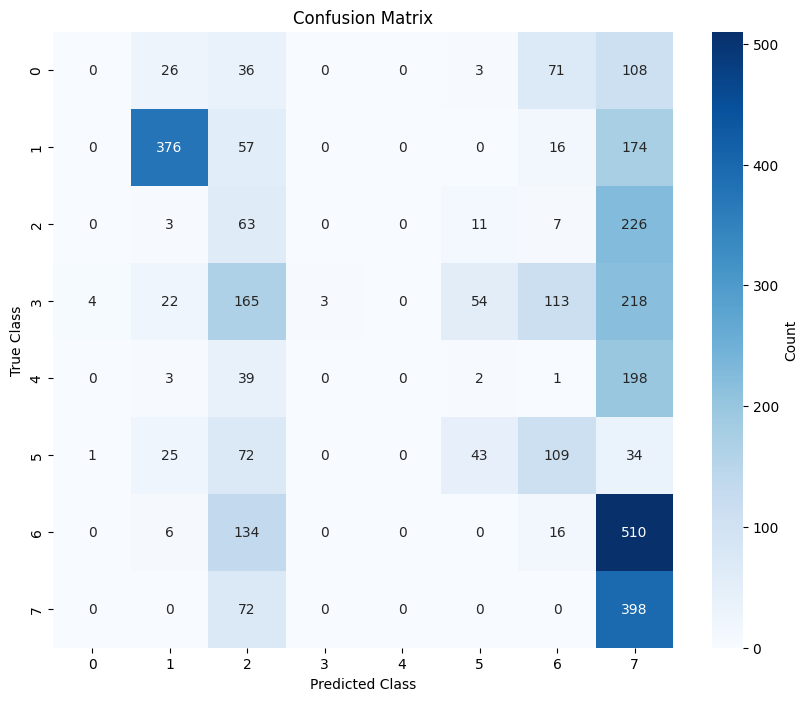

In [ ]:
best_model = load_model("best_model_cnn.h5")

y_pred = best_model.predict((X_test/255.-mean)/std)

# Converting predictions into category labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
confusion = confusion_matrix(y_test, y_pred_classes)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4,5,6,7], yticklabels=[0,1,2,3,4,5,6,7], cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


## Model 3 - PCA+SVM



In [ ]:
%%time
# Create a PCA model
pca = PCA(n_components=800)

# PCA dimensionality reduction on training data
X_train_pca = pca.fit_transform(X.reshape(X.shape[0], -1))
X_val_pca = pca.transform(X_val.reshape(X_val.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1)/255.)

# Create SVM classifier
svm_classifier = SVC()

# Use PCA dimensionality reduction data for training
svm_classifier.fit(X_train_pca, y)

# Predict on the validation set
y_val_pred = svm_classifier.predict(X_val_pca)

# Predict on the test set
y_test_pred = svm_classifier.predict(X_test_pca)

# Evaluate performance on validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred, target_names=['0', '1', '2', '3', '4', '5', '6', '7'], zero_division=1)
print(f'Validation Accuracy: {val_accuracy:.3f}')
print('Validation Classification Report:')
print(val_classification_report)


Validation Accuracy: 0.876
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       196
           1       0.96      0.96      0.96       500
           2       0.94      0.80      0.87       251
           3       0.72      0.82      0.77       447
           4       0.82      0.88      0.85       181
           5       0.82      0.69      0.75       236
           6       0.90      0.95      0.93       554
           7       1.00      0.99      1.00       370

    accuracy                           0.88      2735
   macro avg       0.87      0.85      0.85      2735
weighted avg       0.88      0.88      0.88      2735

CPU times: user 1min 23s, sys: 3.55 s, total: 1min 26s
Wall time: 1min 13s


In [ ]:
# Evaluate performance on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred, target_names=['0', '1', '2', '3', '4', '5', '6', '7'], zero_division=1)
print(f'Test Accuracy: {test_accuracy:.3f}')
print('Test Classification Report:')
print(test_classification_report)

Test Accuracy: 0.866
Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.61      0.67       244
           1       0.97      0.95      0.96       623
           2       0.92      0.83      0.87       310
           3       0.69      0.82      0.75       579
           4       0.83      0.80      0.81       243
           5       0.82      0.70      0.76       284
           6       0.91      0.94      0.92       666
           7       1.00      1.00      1.00       470

    accuracy                           0.87      3419
   macro avg       0.86      0.83      0.84      3419
weighted avg       0.87      0.87      0.87      3419



## Model 4 - Random Forest

In [ ]:
%%time
# Reshaping image data into 2D arrays
normalized_X_train_reshaped = normalized_X.reshape(normalized_X.shape[0], -1)
normalized_X_val_reshaped = normalized_X_val.reshape(normalized_X_val.shape[0], -1)
# Creating a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=180, random_state=42)

# Fitting a model using training data
rf_model.fit(normalized_X_train_reshaped, y)
# Predict
y_pred = rf_model.predict(normalized_X_val_reshaped)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.848
CPU times: user 1min 4s, sys: 78.4 ms, total: 1min 5s
Wall time: 1min 5s


In [ ]:
# predict by model
y_pred = rf_model.predict(((X_test/255.-mean)/std).reshape(X_test.shape[0],-1))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.834


# Hyperparameter tuning

## Model 1 - Fully Connected Neural Network

In [ ]:
def create_model(mlp=[128, 128], activation='relu'):
    """
      mlp: model depths of hidden layers
    """
    layers = [keras.Input(shape=(28, 28, 3)), keras.layers.Flatten()]
    for i, units in enumerate(mlp):
        layers.append(
            keras.layers.Dense(units=units, activation=activation)
        )
    layers.append(keras.layers.Dropout(0.5))
    layers.append(keras.layers.Dense(8, activation="softmax"))

    model = keras.Sequential(layers)
    return model

def run(parameters, create_model_method):
    test_accuracy = []
    for idx, para in enumerate(parameters):
        print(f"[{idx + 1} in {len(parameters)}]: {para}")
        model = create_model_method(**para)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model_checkpoint = ModelCheckpoint("/content/temp.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)

        history = model.fit(
            normalized_X,
            y,
            epochs=15,
            validation_data=(normalized_X_val, y_val),
            callbacks=[model_checkpoint],
            verbose=1
        )

        best_model = load_model("/content/temp.h5")
        _, test_acc = best_model.evaluate(normalized_X_val, y_val)
        test_accuracy.append(test_acc)
    return test_accuracy
parameters = [ # fixing width = 128 and activiation = rele, changing depth
    {'mlp': [128], 'activation': 'relu'},
    {'mlp': [128, 128], 'activation': 'relu'},
    {'mlp': [128, 128, 128], 'activation': 'relu'},
    {'mlp': [128, 128, 128, 128], 'activation': 'relu'},
    {'mlp': [128, 128, 128, 128, 128], 'activation': 'relu'},
    {'mlp': [128, 128, 128, 128, 128,128], 'activation': 'relu'},
]
test_accuracy = run(parameters, create_model)

[1 in 6]: {'mlp': [128], 'activation': 'relu'}
Epoch 1/15
342/342 [==============================] - 3s 6ms/step - loss: 1.2923 - accuracy: 0.6292 - val_loss: 0.5607 - val_accuracy: 0.8099
Epoch 2/15
342/342 [==============================] - 1s 4ms/step - loss: 0.7904 - accuracy: 0.7468 - val_loss: 0.5089 - val_accuracy: 0.8197
Epoch 3/15
342/342 [==============================] - 1s 4ms/step - loss: 0.6646 - accuracy: 0.7724 - val_loss: 0.4797 - val_accuracy: 0.8274
Epoch 4/15
342/342 [==============================] - 1s 4ms/step - loss: 0.6073 - accuracy: 0.7921 - val_loss: 0.4517 - val_accuracy: 0.8351
Epoch 5/15
342/342 [==============================] - 1s 4ms/step - loss: 0.5440 - accuracy: 0.8097 - val_loss: 0.4477 - val_accuracy: 0.8417
Epoch 6/15
342/342 [==============================] - 1s 4ms/step - loss: 0.5271 - accuracy: 0.8162 - val_loss: 0.4399 - val_accuracy: 0.8442
Epoch 7/15
342/342 [==============================] - 1s 4ms/step - loss: 0.4979 - accuracy: 0.8228 -

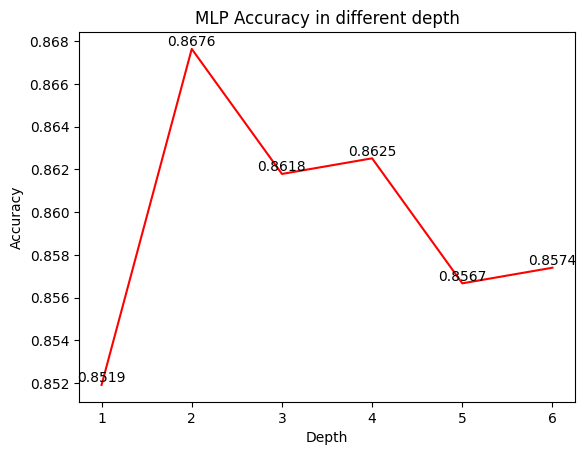

In [ ]:
plt.plot([len(p['mlp']) for p in parameters], test_accuracy, color='r')
plt.ylabel("Accuracy")
plt.xlabel("Depth")
plt.title("MLP Accuracy in different depth")

for i, acc in enumerate(test_accuracy):
    plt.text([len(p['mlp']) for p in parameters][i], acc, f'{acc:.4f}', ha='center', va='bottom')

plt.show()

86/86 [==============================] - 0s 3ms/step - loss: 2.1019 - accuracy: 0.1492


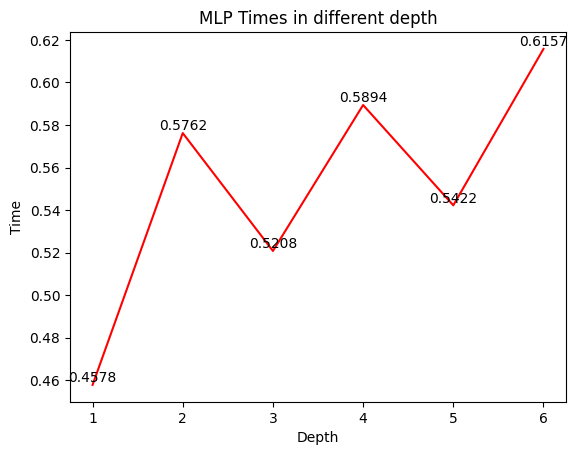

In [ ]:
import time

parameters = [
    {'mlp': [128], 'activation': 'relu'},
    {'mlp': [128, 128], 'activation': 'relu'},
    {'mlp': [128, 128, 128], 'activation': 'relu'},
    {'mlp': [128, 128, 128, 128], 'activation': 'relu'},
    {'mlp': [128, 128, 128, 128, 128], 'activation': 'relu'},
    {'mlp': [128, 128, 128, 128, 128,128], 'activation': 'relu'},
]

times = []
for p in parameters:
    model = create_model(**p)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    model.evaluate(normalized_X_val, y_val)
    end = time.time()
    times.append(end-start)

plt.plot([len(p['mlp']) for p in parameters], times, color='r')
plt.ylabel("Time")
plt.xlabel("Depth")
plt.title("MLP Times in different depth")

for i, acc in enumerate(times):
    plt.text([len(p['mlp']) for p in parameters][i], acc, f'{acc:.4f}', ha='center', va='bottom')

plt.show()

In [ ]:
parameters = [
    {'mlp': [128,128], 'activation': 'relu'},
    {'mlp': [128, 128], 'activation': 'tanh'},
    {'mlp': [128, 128], 'activation': 'leaky_relu'},
]
test_accuracy = run(parameters, create_model)

[1 in 3]: {'mlp': [128, 128], 'activation': 'relu'}
Epoch 1/15
342/342 [==============================] - 4s 5ms/step - loss: 0.9906 - accuracy: 0.6587 - val_loss: 0.5644 - val_accuracy: 0.7941
Epoch 2/15
342/342 [==============================] - 1s 4ms/step - loss: 0.6396 - accuracy: 0.7703 - val_loss: 0.4842 - val_accuracy: 0.8293
Epoch 3/15
342/342 [==============================] - 1s 4ms/step - loss: 0.5458 - accuracy: 0.8051 - val_loss: 0.4602 - val_accuracy: 0.8355
Epoch 4/15
342/342 [==============================] - 1s 4ms/step - loss: 0.4824 - accuracy: 0.8246 - val_loss: 0.4492 - val_accuracy: 0.8428
Epoch 5/15
342/342 [==============================] - 1s 4ms/step - loss: 0.4358 - accuracy: 0.8405 - val_loss: 0.4600 - val_accuracy: 0.8388
Epoch 6/15
342/342 [==============================] - 1s 4ms/step - loss: 0.4007 - accuracy: 0.8546 - val_loss: 0.4522 - val_accuracy: 0.8435
Epoch 7/15
342/342 [==============================] - 2s 5ms/step - loss: 0.3655 - accuracy: 0.8

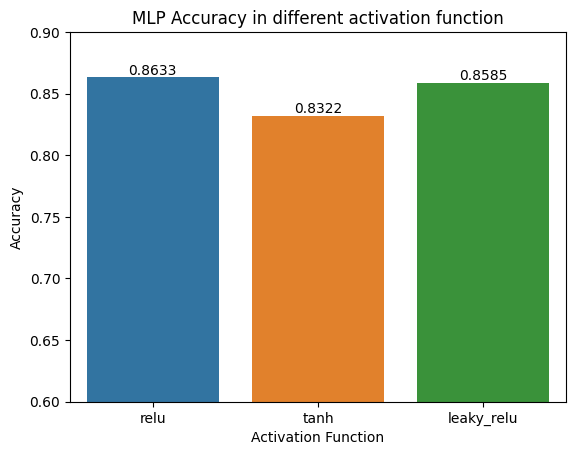

In [ ]:
sns.barplot(x=[p['activation'] for p in parameters], y=test_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Activation Function")
plt.title("MLP Accuracy in different activation function")
plt.ylim(0.6, 0.9)
for i, v in enumerate(test_accuracy):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.show()

86/86 [==============================] - 1s 5ms/step - loss: 2.5855 - accuracy: 0.0680


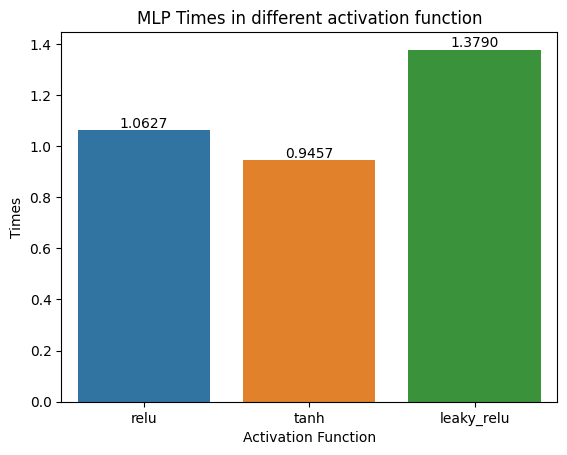

In [ ]:
import time

parameters = [
    {'mlp': [128,128], 'activation': 'relu'},
    {'mlp': [128, 128], 'activation': 'tanh'},
    {'mlp': [128, 128], 'activation': 'leaky_relu'},
]

times = []
for p in parameters:
    model = create_model(**p)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    model.evaluate(normalized_X_val, y_val)
    end = time.time()
    times.append(end-start)

sns.barplot(x=[p['activation'] for p in parameters], y=times)
plt.ylabel("Times")
plt.xlabel("Activation Function")
plt.title("MLP Times in different activation function")
for i, v in enumerate(times):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.show()

In [ ]:
parameters = [
    {'mlp': [64,64], 'activation': 'relu'},
    {'mlp': [128, 128], 'activation': 'relu'},
    {'mlp': [256, 256], 'activation': 'relu'},
    {'mlp': [512, 512], 'activation': 'relu'},
]
test_accuracy = run(parameters, create_model)

[1 in 4]: {'mlp': [64, 64], 'activation': 'relu'}
Epoch 1/15
342/342 [==============================] - 3s 5ms/step - loss: 1.0983 - accuracy: 0.6132 - val_loss: 0.5856 - val_accuracy: 0.7868
Epoch 2/15
 52/342 [===>..........................] - ETA: 0s - loss: 0.7762 - accuracy: 0.7194

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


342/342 [==============================] - 1s 4ms/step - loss: 0.7087 - accuracy: 0.7464 - val_loss: 0.5294 - val_accuracy: 0.8143
Epoch 3/15
342/342 [==============================] - 1s 4ms/step - loss: 0.6051 - accuracy: 0.7782 - val_loss: 0.4885 - val_accuracy: 0.8230
Epoch 4/15
342/342 [==============================] - 1s 4ms/step - loss: 0.5430 - accuracy: 0.8009 - val_loss: 0.4735 - val_accuracy: 0.8274
Epoch 5/15
342/342 [==============================] - 3s 9ms/step - loss: 0.4956 - accuracy: 0.8167 - val_loss: 0.4793 - val_accuracy: 0.8278
Epoch 6/15
342/342 [==============================] - 2s 4ms/step - loss: 0.4648 - accuracy: 0.8286 - val_loss: 0.4590 - val_accuracy: 0.8410
Epoch 7/15
342/342 [==============================] - 1s 4ms/step - loss: 0.4262 - accuracy: 0.8396 - val_loss: 0.4444 - val_accuracy: 0.8410
Epoch 8/15
342/342 [==============================] - 1s 4ms/step - loss: 0.3951 - accuracy: 0.8504 - val_loss: 0.4855 - val_accuracy: 0.8450
Epoch 9/15
342/34

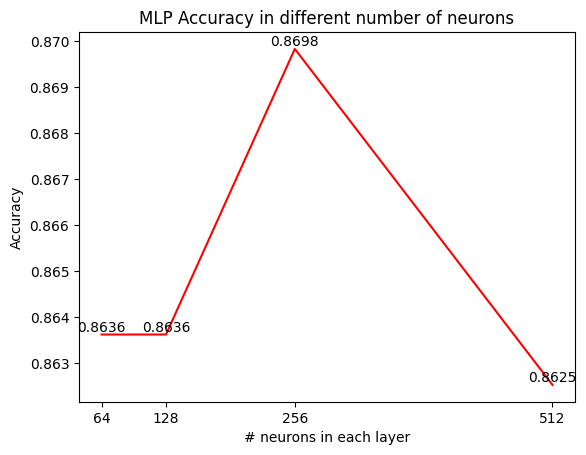

In [ ]:
plt.plot([p['mlp'][0] for p in parameters], test_accuracy, color='r')
xticks = []

for i in range(1, len(test_accuracy) - 1):
    if test_accuracy[i] > test_accuracy[i - 1] and test_accuracy[i] > test_accuracy[i + 1]:
        xticks.append(i)
plt.ylabel("Accuracy")
plt.xlabel("# neurons in each layer")
plt.title("MLP Accuracy in different number of neurons")
plt.xticks([p['mlp'][0] for p in parameters], [p['mlp'][0] for p in parameters])
for i, acc in enumerate(test_accuracy):
    plt.text([p['mlp'][0] for p in parameters][i], acc, f'{acc:.4f}', ha='center', va='bottom')
plt.show()

86/86 [==============================] - 0s 3ms/step - loss: 2.4127 - accuracy: 0.1291


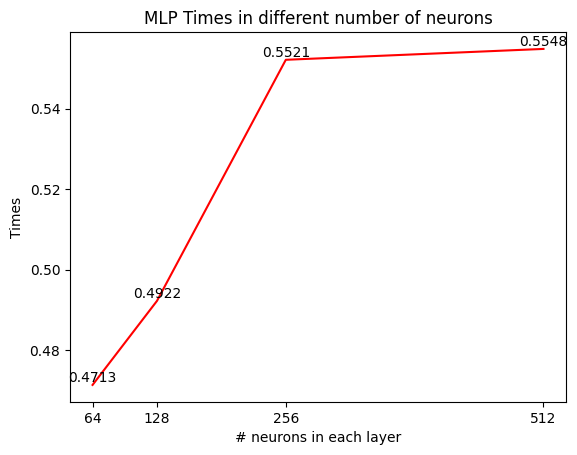

In [ ]:
import time

parameters = [
    {'mlp': [64,64], 'activation': 'relu'},
    {'mlp': [128, 128], 'activation': 'relu'},
    {'mlp': [256, 256], 'activation': 'relu'},
    {'mlp': [512, 512], 'activation': 'relu'},
]

times = []
for p in parameters:
    model = create_model(**p)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    model.evaluate(normalized_X_val, y_val)
    end = time.time()
    times.append(end-start)

plt.plot([p['mlp'][0] for p in parameters], times, color='r')
xticks = []

for i in range(1, len(times) - 1):
    if times[i] > times[i - 1] and times[i] > times[i + 1]:
        xticks.append(i)
plt.ylabel("Times")
plt.xlabel("# neurons in each layer")
plt.title("MLP Times in different number of neurons")
plt.xticks([p['mlp'][0] for p in parameters], [p['mlp'][0] for p in parameters])
for i, acc in enumerate(times):
    plt.text([p['mlp'][0] for p in parameters][i], acc, f'{acc:.4f}', ha='center', va='bottom')
plt.show()

## Model 2 - Convolutional Neural Network

In [ ]:
def create_model(depths=[[32, 32, 32], [64, 64, 64], [128, 128, 128]], kernel_size=3, strides=1, activation='relu'):
    """
      mlp: model depths of hidden layers
    """
    layers = [keras.Input(shape=(28, 28, 3))]
    for dep_units in depths:
        for channel in dep_units:
            layers.append(keras.layers.Conv2D(channel, kernel_size=(kernel_size, kernel_size),
                                              strides=(strides, strides), activation=activation, padding='same'))
        layers.append(keras.layers.AvgPool2D(pool_size=(2, 2)))
    layers += [
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(8, activation="softmax"),
    ]
    model = keras.Sequential(layers)
    return model



def run(parameters, create_model_method):
    test_accuracy = []
    for idx, para in enumerate(parameters):
        print(f"[{idx + 1} in {len(parameters)}]: {para}")
        model = create_model_method(**para)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model_checkpoint = ModelCheckpoint("/content/temp.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)

        history = model.fit(
            my_generator(X255,y,batch_size=256),
            steps_per_epoch=len(X255) // 256,
            epochs=30,
            validation_data=(normalized_X255_val, y_val),
            callbacks=[model_checkpoint],
            verbose=1
        )

        best_model = load_model("/content/temp.h5")
        _, test_acc = best_model.evaluate(normalized_X255_val, y_val)
        test_accuracy.append(test_acc)
    return test_accuracy

c = 64
parameters = [
    {'depths': [[c, c, c]], 'kernel_size':3, 'strides':1, 'activation':'relu'},
    {'depths': [[c, c, c], [c*2, c*2, c*2]], 'kernel_size':3, 'strides':1, 'activation':'relu'},
    {'depths': [[c, c, c], [c*2, c*2, c*2], [c*4, c*4, c*4]], 'kernel_size':3, 'strides':1, 'activation':'relu'},
]
test_accuracy = run(parameters, create_model)

[1 in 3]: {'depths': [[64, 64, 64]], 'kernel_size': 3, 'strides': 1, 'activation': 'relu'}
Epoch 1/30
42/42 [==============================] - 5s 87ms/step - loss: 1.3772 - accuracy: 0.5079 - val_loss: 0.7458 - val_accuracy: 0.7514
Epoch 2/30
42/42 [==============================] - 5s 117ms/step - loss: 0.7044 - accuracy: 0.7494 - val_loss: 0.4752 - val_accuracy: 0.8435
Epoch 3/30
42/42 [==============================] - 4s 93ms/step - loss: 0.5804 - accuracy: 0.7970 - val_loss: 0.4094 - val_accuracy: 0.8611
Epoch 4/30
42/42 [==============================] - 3s 80ms/step - loss: 0.5147 - accuracy: 0.8174 - val_loss: 0.3880 - val_accuracy: 0.8724
Epoch 5/30
42/42 [==============================] - 3s 76ms/step - loss: 0.4775 - accuracy: 0.8327 - val_loss: 0.3381 - val_accuracy: 0.8826
Epoch 6/30
42/42 [==============================] - 5s 121ms/step - loss: 0.4289 - accuracy: 0.8478 - val_loss: 0.3053 - val_accuracy: 0.8929
Epoch 7/30
42/42 [==============================] - 3s 69ms/s

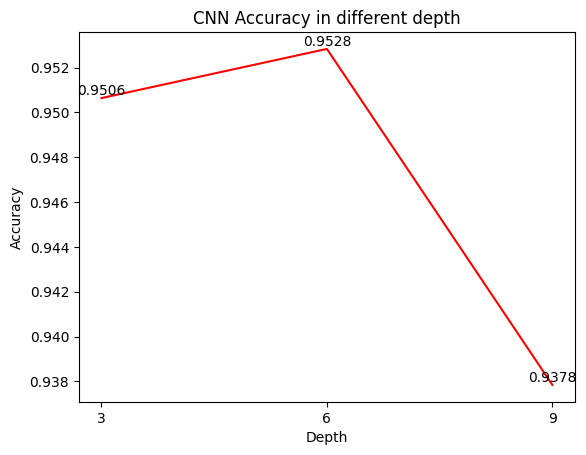

In [ ]:
xlabels = []
for p in parameters:
  depth = 0
  for d in p['depths']:
    depth += len(d)
  xlabels.append(depth)
plt.plot(xlabels, test_accuracy, color='r')
xticks = []

for i in range(1, len(test_accuracy) - 1):
    if test_accuracy[i] > test_accuracy[i - 1] and test_accuracy[i] > test_accuracy[i + 1]:
        xticks.append(i)
plt.ylabel("Accuracy")
plt.xlabel("Depth")
plt.title("CNN Accuracy in different depth")
plt.xticks(xlabels, xlabels)
for i, acc in enumerate(test_accuracy):
    plt.text(xlabels[i], acc, f'{acc:.4f}', ha='center', va='bottom')
plt.show()

86/86 [==============================] - 1s 6ms/step - loss: 2.0806 - accuracy: 0.0888


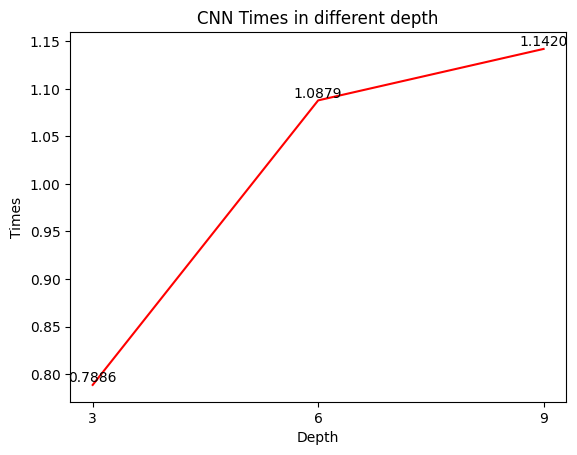

In [ ]:
import time

c = 64
parameters = [
    {'depths': [[c, c, c]], 'kernel_size':3, 'strides':1, 'activation':'relu'},
    {'depths': [[c, c, c], [c*2, c*2, c*2]], 'kernel_size':3, 'strides':1, 'activation':'relu'},
    {'depths': [[c, c, c], [c*2, c*2, c*2], [c*4, c*4, c*4]], 'kernel_size':3, 'strides':1, 'activation':'relu'},
]

times = []
for p in parameters:
    model = create_model(**p)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    model.evaluate(normalized_X_val, y_val)
    end = time.time()
    times.append(end-start)

xlabels = []
for p in parameters:
  depth = 0
  for d in p['depths']:
    depth += len(d)
  xlabels.append(depth)
plt.plot(xlabels, times, color='r')
xticks = []

for i in range(1, len(times) - 1):
    if times[i] > times[i - 1] and times[i] > times[i + 1]:
        xticks.append(i)
plt.ylabel("Times")
plt.xlabel("Depth")
plt.title("CNN Times in different depth")
plt.xticks(xlabels, xlabels)
for i, acc in enumerate(times):
    plt.text(xlabels[i], acc, f'{acc:.4f}', ha='center', va='bottom')
plt.show()

In [ ]:
c = 64
parameters = [
    {'depths': [[c, c, c], [c*2, c*2, c*2]], 'kernel_size':3, 'strides':1, 'activation':'relu'},
    {'depths': [[c, c, c], [c*2, c*2, c*2]], 'kernel_size':5, 'strides':1, 'activation':'relu'},
    {'depths': [[c, c, c], [c*2, c*2, c*2]],  'kernel_size':7, 'strides':1, 'activation':'relu'},
]
test_accuracy = run(parameters, create_model)

[1 in 3]: {'depths': [[64, 64, 64], [128, 128, 128]], 'kernel_size': 3, 'strides': 1, 'activation': 'relu'}
Epoch 1/30
42/42 [==============================] - 8s 118ms/step - loss: 1.4751 - accuracy: 0.4330 - val_loss: 1.0464 - val_accuracy: 0.5506
Epoch 2/30
42/42 [==============================] - 6s 143ms/step - loss: 0.8616 - accuracy: 0.6840 - val_loss: 0.5470 - val_accuracy: 0.7956
Epoch 3/30
42/42 [==============================] - 4s 108ms/step - loss: 0.6641 - accuracy: 0.7604 - val_loss: 0.4364 - val_accuracy: 0.8402
Epoch 4/30
42/42 [==============================] - 4s 104ms/step - loss: 0.5762 - accuracy: 0.7953 - val_loss: 0.4282 - val_accuracy: 0.8508
Epoch 5/30
42/42 [==============================] - 3s 84ms/step - loss: 0.5097 - accuracy: 0.8233 - val_loss: 0.3646 - val_accuracy: 0.8665
Epoch 6/30
42/42 [==============================] - 4s 91ms/step - loss: 0.4415 - accuracy: 0.8398 - val_loss: 0.3511 - val_accuracy: 0.8739
Epoch 7/30
42/42 [========================

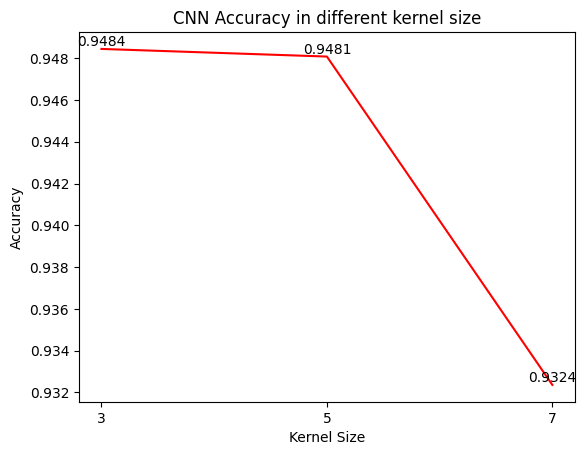

In [ ]:
plt.plot([p['kernel_size'] for p in parameters], test_accuracy, color='r')

for i in range(1, len(test_accuracy) - 1):
    if test_accuracy[i] > test_accuracy[i - 1] and test_accuracy[i] > test_accuracy[i + 1]:
        xticks.append(i)
plt.ylabel("Accuracy")
plt.xlabel("Kernel Size")
plt.title("CNN Accuracy in different kernel size")
plt.xticks([p['kernel_size'] for p in parameters], [p['kernel_size'] for p in parameters])
for i, acc in enumerate(test_accuracy):
    plt.text([p['kernel_size'] for p in parameters][i], acc, f'{acc:.4f}', ha='center', va='bottom')
plt.show()

86/86 [==============================] - 1s 9ms/step - loss: 2.0757 - accuracy: 0.1349


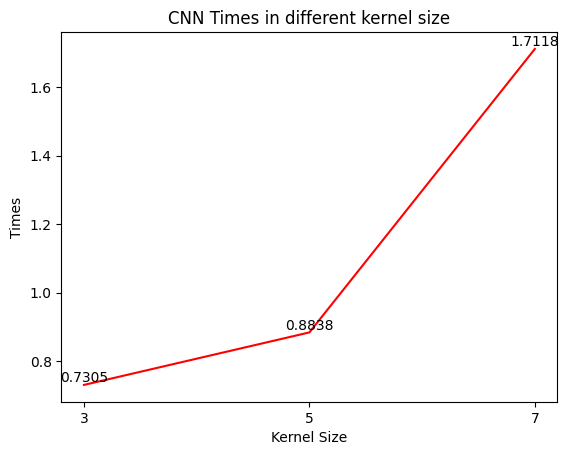

In [ ]:
import time

c = 64
parameters = [
    {'depths': [[c, c, c], [c*2, c*2, c*2]], 'kernel_size':3, 'strides':1, 'activation':'relu'},
    {'depths': [[c, c, c], [c*2, c*2, c*2]], 'kernel_size':5, 'strides':1, 'activation':'relu'},
    {'depths': [[c, c, c], [c*2, c*2, c*2]],  'kernel_size':7, 'strides':1, 'activation':'relu'},
]

times = []
for p in parameters:
    model = create_model(**p)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    model.evaluate(normalized_X_val, y_val)
    end = time.time()
    times.append(end-start)

plt.plot([p['kernel_size'] for p in parameters], times, color='r')

for i in range(1, len(times) - 1):
    if times[i] > times[i - 1] and times[i] > times[i + 1]:
        xticks.append(i)
plt.ylabel("Times")
plt.xlabel("Kernel Size")
plt.title("CNN Times in different kernel size")
plt.xticks([p['kernel_size'] for p in parameters], [p['kernel_size'] for p in parameters])
for i, acc in enumerate(times):
    plt.text([p['kernel_size'] for p in parameters][i], acc, f'{acc:.4f}', ha='center', va='bottom')
plt.show()

In [ ]:
c = 64
parameters = [
    {'depths': [[c, c, c], [c*2, c*2, c*2]], 'kernel_size':3, 'strides':1, 'activation':'relu'},
    {'depths': [[c, c, c], [c*2, c*2, c*2]], 'kernel_size':3, 'strides':1, 'activation':'tanh'},
    {'depths': [[c, c, c], [c*2, c*2, c*2]],  'kernel_size':3, 'strides':1, 'activation':'leaky_relu'},
]
test_accuracy = run(parameters, create_model)

[1 in 3]: {'depths': [[64, 64, 64], [128, 128, 128]], 'kernel_size': 3, 'strides': 1, 'activation': 'relu'}
Epoch 1/30
42/42 [==============================] - 8s 92ms/step - loss: 1.3547 - accuracy: 0.4982 - val_loss: 0.8417 - val_accuracy: 0.7188
Epoch 2/30
 3/42 [=>............................] - ETA: 1s - loss: 0.8932 - accuracy: 0.6834

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 4s 90ms/step - loss: 0.7480 - accuracy: 0.7216 - val_loss: 0.5123 - val_accuracy: 0.8234
Epoch 3/30
42/42 [==============================] - 6s 145ms/step - loss: 0.5801 - accuracy: 0.7889 - val_loss: 0.4907 - val_accuracy: 0.8329
Epoch 4/30
42/42 [==============================] - 4s 90ms/step - loss: 0.5225 - accuracy: 0.8115 - val_loss: 0.3725 - val_accuracy: 0.8753
Epoch 5/30
42/42 [==============================] - 3s 81ms/step - loss: 0.4540 - accuracy: 0.8402 - val_loss: 0.3327 - val_accuracy: 0.8910
Epoch 6/30
42/42 [==============================] - 4s 102ms/step - loss: 0.4310 - accuracy: 0.8481 - val_loss: 0.3187 - val_accuracy: 0.8914
Epoch 7/30
42/42 [==============================] - 4s 103ms/step - loss: 0.3855 - accuracy: 0.8668 - val_loss: 0.3137 - val_accuracy: 0.8947
Epoch 8/30
42/42 [==============================] - 4s 86ms/step - loss: 0.3657 - accuracy: 0.8731 - val_loss: 0.2716 - val_accuracy: 0.9174
Epoch 9/30
42/42 [===

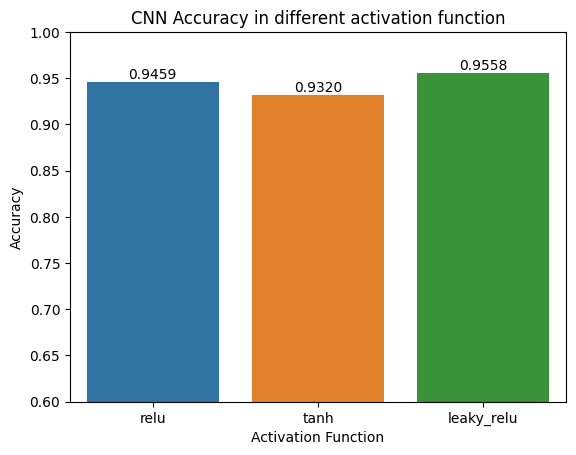

In [ ]:
sns.barplot(x=[p['activation'] for p in parameters], y=test_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Activation Function")
plt.title("CNN Accuracy in different activation function")
plt.ylim(0.6, 1.0)
for i, v in enumerate(test_accuracy):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.show()

86/86 [==============================] - 1s 5ms/step - loss: 2.0779 - accuracy: 0.1276


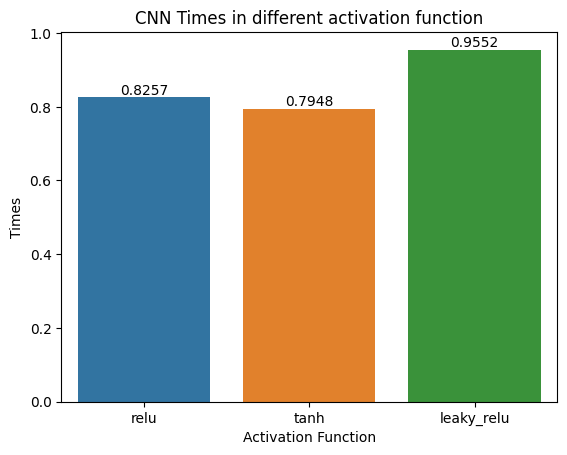

In [ ]:
import time

c = 64
parameters = [
    {'depths': [[c, c, c], [c*2, c*2, c*2]], 'kernel_size':3, 'strides':1, 'activation':'relu'},
    {'depths': [[c, c, c], [c*2, c*2, c*2]], 'kernel_size':3, 'strides':1, 'activation':'tanh'},
    {'depths': [[c, c, c], [c*2, c*2, c*2]],  'kernel_size':3, 'strides':1, 'activation':'leaky_relu'},
]
times = []
for p in parameters:
    model = create_model(**p)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    model.evaluate(normalized_X_val, y_val)
    end = time.time()
    times.append(end-start)

sns.barplot(x=[p['activation'] for p in parameters], y=times)
plt.ylabel("Times")
plt.xlabel("Activation Function")
plt.title("CNN Times in different activation function")
for i, v in enumerate(times):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.show()

In [ ]:
parameters = [
    {'depths': [[32, 32, 32], [32*2, 32*2, 32*2]],  'kernel_size':3, 'strides':1, 'activation':'leaky_relu'},
    {'depths': [[64, 64, 64], [64*2, 64*2, 64*2]], 'kernel_size':3, 'strides':1, 'activation':'leaky_relu'},
    {'depths': [[128, 128, 128], [128*2, 128*2, 128*2]], 'kernel_size':3, 'strides':1, 'activation':'leaky_relu'},
]
test_accuracy = run(parameters, create_model)

[1 in 3]: {'depths': [[32, 32, 32], [64, 64, 64]], 'kernel_size': 3, 'strides': 1, 'activation': 'leaky_relu'}
Epoch 1/30
42/42 [==============================] - 8s 105ms/step - loss: 1.3990 - accuracy: 0.4707 - val_loss: 0.8087 - val_accuracy: 0.7199
Epoch 2/30
42/42 [==============================] - 4s 83ms/step - loss: 0.7993 - accuracy: 0.7060 - val_loss: 0.6209 - val_accuracy: 0.7616
Epoch 3/30
42/42 [==============================] - 4s 101ms/step - loss: 0.6504 - accuracy: 0.7642 - val_loss: 0.4837 - val_accuracy: 0.8333
Epoch 4/30
42/42 [==============================] - 4s 96ms/step - loss: 0.5322 - accuracy: 0.8101 - val_loss: 0.4711 - val_accuracy: 0.8260
Epoch 5/30
42/42 [==============================] - 3s 79ms/step - loss: 0.4967 - accuracy: 0.8185 - val_loss: 0.3966 - val_accuracy: 0.8570
Epoch 6/30
42/42 [==============================] - 4s 88ms/step - loss: 0.4496 - accuracy: 0.8353 - val_loss: 0.3792 - val_accuracy: 0.8706
Epoch 7/30
42/42 [=======================

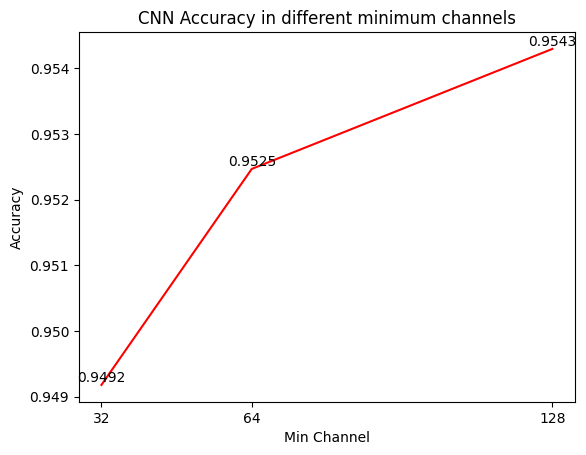

In [ ]:
xlabels = []
for p in parameters:
   xlabels.append(p['depths'][0][0])
plt.plot(xlabels, test_accuracy, color='r')
xticks = []

for i in range(1, len(test_accuracy) - 1):
    if test_accuracy[i] > test_accuracy[i - 1] and test_accuracy[i] > test_accuracy[i + 1]:
        xticks.append(i)
plt.ylabel("Accuracy")
plt.xlabel("Min Channel")
plt.title("CNN Accuracy in different minimum channels")
plt.xticks(xlabels, xlabels)
for i, acc in enumerate(test_accuracy):
    plt.text(xlabels[i], acc, f'{acc:.4f}', ha='center', va='bottom')
plt.show()

86/86 [==============================] - 1s 8ms/step - loss: 2.0778 - accuracy: 0.1122


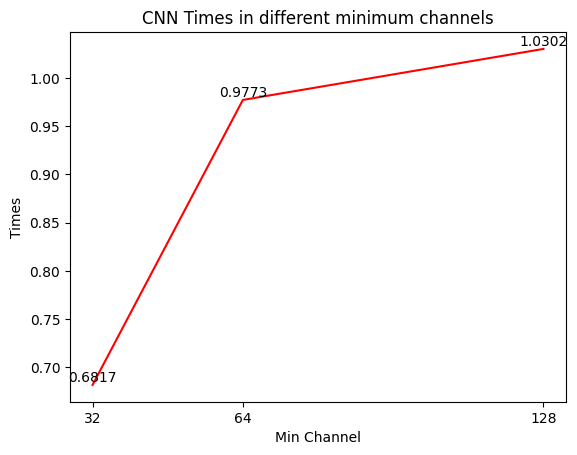

In [ ]:
import time

parameters = [
    {'depths': [[32, 32, 32], [32*2, 32*2, 32*2]],  'kernel_size':3, 'strides':1, 'activation':'leaky_relu'},
    {'depths': [[64, 64, 64], [64*2, 64*2, 64*2]], 'kernel_size':3, 'strides':1, 'activation':'leaky_relu'},
    {'depths': [[128, 128, 128], [128*2, 128*2, 128*2]], 'kernel_size':3, 'strides':1, 'activation':'leaky_relu'},
]
times = []
for p in parameters:
    model = create_model(**p)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    model.evaluate(normalized_X_val, y_val)
    end = time.time()
    times.append(end-start)

xlabels = []
for p in parameters:
   xlabels.append(p['depths'][0][0])
plt.plot(xlabels, times, color='r')
xticks = []

for i in range(1, len(times) - 1):
    if times[i] > times[i - 1] and times[i] > times[i + 1]:
        xticks.append(i)
plt.ylabel("Times")
plt.xlabel("Min Channel")
plt.title("CNN Times in different minimum channels")
plt.xticks(xlabels, xlabels)
for i, acc in enumerate(times):
    plt.text(xlabels[i], acc, f'{acc:.4f}', ha='center', va='bottom')
plt.show()

## Model 3 - PCA+SVM

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

def run(parameters):
    test_accuracy = []
    best_parameters = None
    best_acc = -1
    i = 0
    times = []
    for n_components in param_grid['pca__n_components']:
        for C in param_grid['svc__C']:
            for kernel in param_grid['svc__kernel']:
                i += 1
                print(f"[{i}|{len(param_grid['pca__n_components']) * len(param_grid['svc__C']) * len(param_grid['svc__kernel'])}]", end="")
                print(f" n_components={n_components}, C={C}, kernel={kernel}", end="")
                pca = PCA(n_components=n_components, random_state=42)
                svc = SVC(C=C, kernel=kernel, random_state=42)
                model = Pipeline([
                    ('pca', pca),
                    ('svc', svc),
                ])
                model.fit(X.reshape(X.shape[0], -1), y)
                start = time.time()
                y_pred = model.predict(X_val.reshape(X_val.shape[0], -1))
                end = time.time()
                accuracy = accuracy_score(y_val, y_pred)
                print(f" accuracy={accuracy:.4f}")
                if accuracy > best_acc:
                    best_acc = accuracy
                    best_parameters = f"n_components={n_components}, C={C}, kernel={kernel}"
                test_accuracy.append(accuracy)
                times.append(end-start)
    print(f"{best_parameters}, best_accuracy={best_acc:.4f}")
    return test_accuracy, times


param_grid = {
    'pca__n_components': [200,400,800],
    'svc__C': [1],
    'svc__kernel': ['linear']
}

test_accuracy, times = run(param_grid)

[1|3] n_components=200, C=1, kernel=linear accuracy=0.8358
[2|3] n_components=400, C=1, kernel=linear accuracy=0.8501
[3|3] n_components=800, C=1, kernel=linear accuracy=0.8399
n_components=400, C=1, kernel=linear, best_accuracy=0.8501


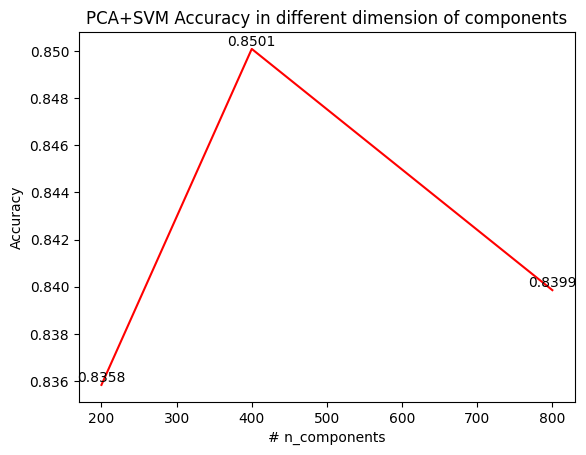

In [ ]:
plt.plot([p for p in param_grid['pca__n_components']], test_accuracy, color='r')
plt.ylabel("Accuracy")
plt.xlabel("# n_components")
plt.title("PCA+SVM Accuracy in different dimension of components")

for i, acc in enumerate(test_accuracy):
    plt.text([p for p in param_grid['pca__n_components']][i], acc, f'{acc:.4f}', ha='center', va='bottom')

plt.show()

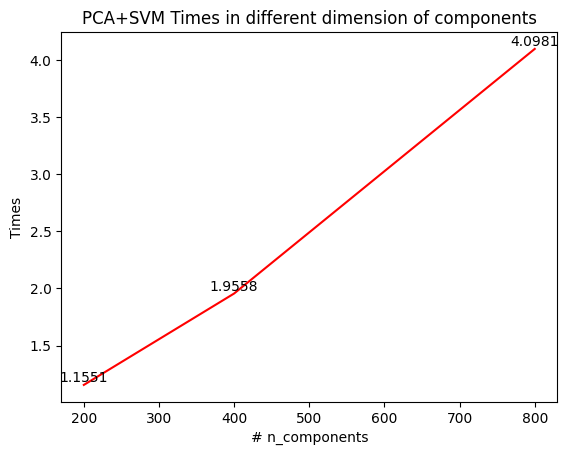

In [ ]:
plt.plot([p for p in param_grid['pca__n_components']], times, color='r')
plt.ylabel("Times")
plt.xlabel("# n_components")
plt.title("PCA+SVM Times in different dimension of components")

for i, acc in enumerate(times):
    plt.text([p for p in param_grid['pca__n_components']][i], acc, f'{acc:.4f}', ha='center', va='bottom')

plt.show()

In [ ]:
param_grid = {
    'pca__n_components': [400],
    'svc__C': [0.01, 0.1, 1, 10],
    'svc__kernel': ['linear']
}

test_accuracy, times = run(param_grid)

[1|4] n_components=400, C=0.01, kernel=linear accuracy=0.8091
[2|4] n_components=400, C=0.1, kernel=linear accuracy=0.8431
[3|4] n_components=400, C=1, kernel=linear accuracy=0.8501
[4|4] n_components=400, C=10, kernel=linear accuracy=0.8223
n_components=400, C=1, kernel=linear, best_accuracy=0.8501


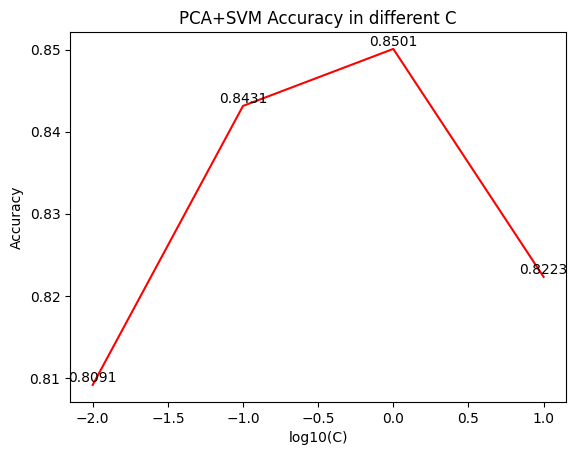

In [ ]:
import math

plt.plot([math.log10(p) for p in param_grid['svc__C']], test_accuracy, color='r')
plt.ylabel("Accuracy")
plt.xlabel("log10(C)")
plt.title("PCA+SVM Accuracy in different C")

for i, acc in enumerate(test_accuracy):
    plt.text([math.log10(p) for p in param_grid['svc__C']][i], acc, f'{acc:.4f}', ha='center', va='bottom')

plt.show()

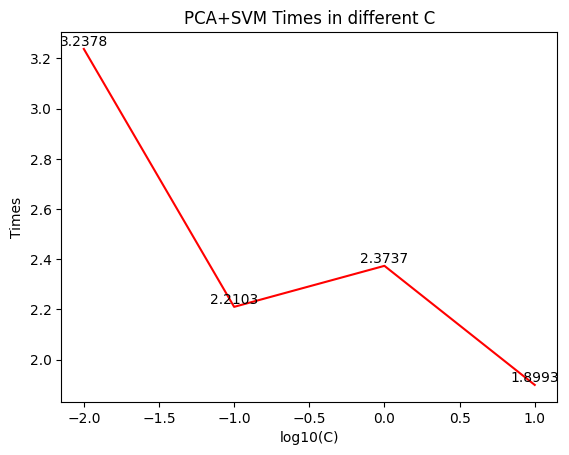

In [ ]:
plt.plot([math.log10(p) for p in param_grid['svc__C']], times, color='r')
plt.ylabel("Times")
plt.xlabel("log10(C)")
plt.title("PCA+SVM Times in different C")

for i, acc in enumerate(times):
    plt.text([math.log10(p) for p in param_grid['svc__C']][i], acc, f'{acc:.4f}', ha='center', va='bottom')

plt.show()

In [ ]:
param_grid = {
    'pca__n_components': [400],
    'svc__C': [1],
    'svc__kernel': ['linear', 'rbf', 'sigmoid']
}

test_accuracy, times = run(param_grid)

[1|3] n_components=400, C=1, kernel=linear accuracy=0.8501
[2|3] n_components=400, C=1, kernel=rbf accuracy=0.8775
[3|3] n_components=400, C=1, kernel=sigmoid accuracy=0.6757
n_components=400, C=1, kernel=rbf, best_accuracy=0.8775


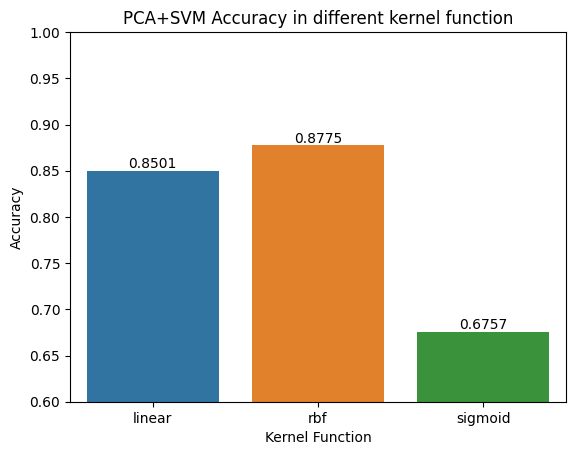

In [ ]:
sns.barplot(x=[p for p in param_grid['svc__kernel']], y=test_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Kernel Function")
plt.title("PCA+SVM Accuracy in different kernel function")
plt.ylim(0.6, 1.0)
for i, v in enumerate(test_accuracy):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.show()

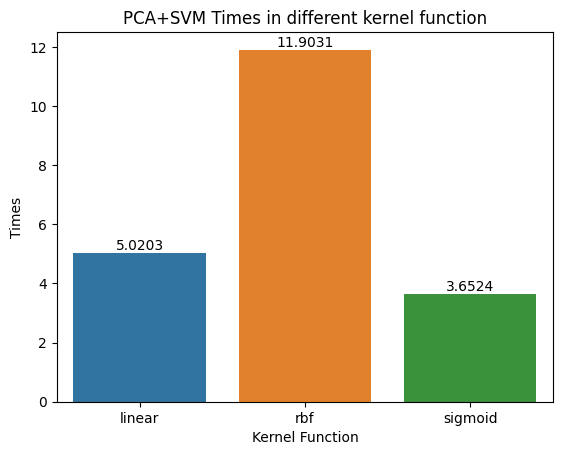

In [ ]:
sns.barplot(x=[p for p in param_grid['svc__kernel']], y=times)
plt.ylabel("Times")
plt.xlabel("Kernel Function")
plt.title("PCA+SVM Times in different kernel function")
for i, v in enumerate(times):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.show()

## Model 4 - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def run(parameters):
    test_accuracy = []
    best_parameters = None
    best_acc = -1
    i = 0
    times = []
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for criterion in param_grid['criterion']:
                i += 1
                print(f"[{i}|{len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['criterion'])}]", end="")
                print(f" n_estimators={n_estimators}, max_depth={max_depth}, criterion={criterion}", end="")
                model = RandomForestClassifier(n_estimators=n_estimators,
                                               max_depth=max_depth,
                                               criterion=criterion,
                                               random_state=42)

                model.fit(normalized_X.reshape(normalized_X.shape[0], -1), y)
                start = time.time()
                y_pred = model.predict(normalized_X_val.reshape(normalized_X_val.shape[0], -1))
                end = time.time()
                accuracy = accuracy_score(y_val, y_pred)
                print(f" accuracy={accuracy:.4f}")
                if accuracy > best_acc:
                    best_acc = accuracy
                    best_parameters = f"n_estimators={n_estimators}, max_depth={max_depth}, criterion={criterion}"
                test_accuracy.append(accuracy)
                times.append(end - start)
    print(f"{best_parameters}, best_accuracy={best_acc:.4f}")
    return test_accuracy, times


param_grid = {
    'n_estimators': [10, 50 ,100, 200],
    'max_depth': [100],
    'criterion': ['gini'],
}

test_accuracy, times = run(param_grid)

[1|4] n_estimators=10, max_depth=100, criterion=gini accuracy=0.7810
[2|4] n_estimators=50, max_depth=100, criterion=gini accuracy=0.8380
[3|4] n_estimators=100, max_depth=100, criterion=gini accuracy=0.8417
[4|4] n_estimators=200, max_depth=100, criterion=gini accuracy=0.8442
n_estimators=200, max_depth=100, criterion=gini, best_accuracy=0.8442


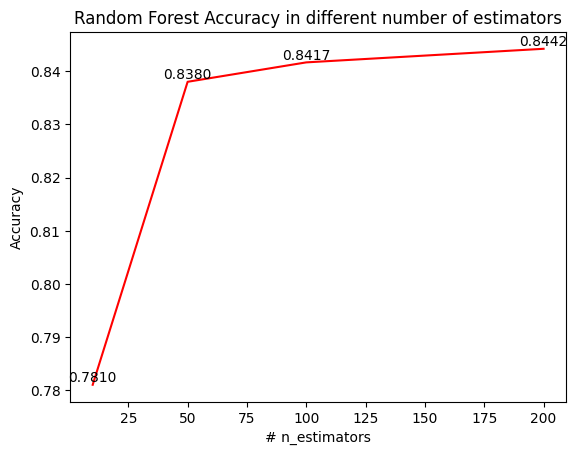

In [ ]:
plt.plot([p for p in param_grid['n_estimators']], test_accuracy, color='r')
plt.ylabel("Accuracy")
plt.xlabel("# n_estimators")
plt.title("Random Forest Accuracy in different number of estimators")

for i, acc in enumerate(test_accuracy):
    plt.text([p for p in param_grid['n_estimators']][i], acc, f'{acc:.4f}', ha='center', va='bottom')

plt.show()

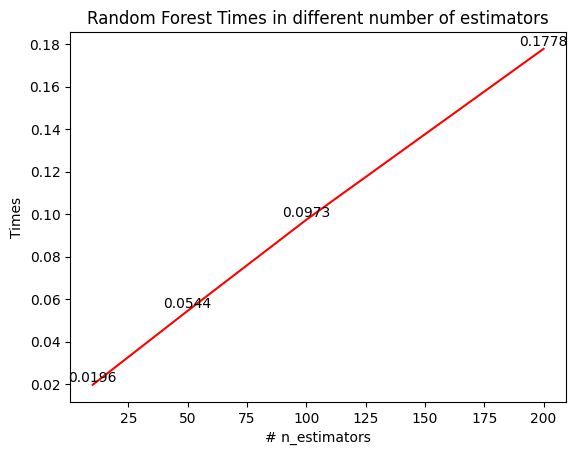

In [ ]:
plt.plot([p for p in param_grid['n_estimators']], times, color='r')
plt.ylabel("Times")
plt.xlabel("# n_estimators")
plt.title("Random Forest Times in different number of estimators")

for i, acc in enumerate(times):
    plt.text([p for p in param_grid['n_estimators']][i], acc, f'{acc:.4f}', ha='center', va='bottom')

plt.show()

In [ ]:
param_grid = {
    'n_estimators': [200],
    'max_depth': [10, 50, 100, 200],
    'criterion': ['gini'],
}

test_accuracy, times = run(param_grid)

[1|4] n_estimators=200, max_depth=10, criterion=gini accuracy=0.8026
[2|4] n_estimators=200, max_depth=50, criterion=gini accuracy=0.8442
[3|4] n_estimators=200, max_depth=100, criterion=gini accuracy=0.8442
[4|4] n_estimators=200, max_depth=200, criterion=gini accuracy=0.8442
n_estimators=200, max_depth=50, criterion=gini, best_accuracy=0.8442


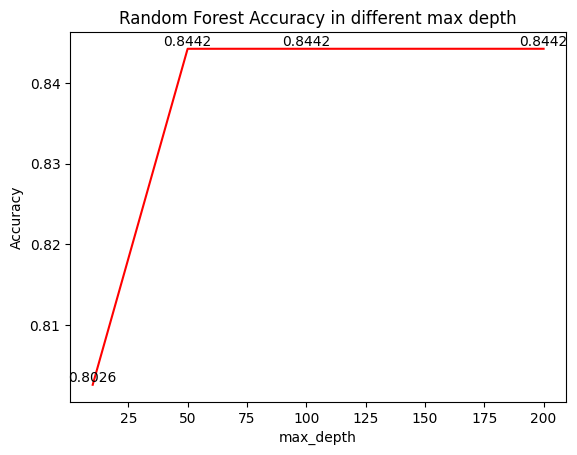

In [ ]:
plt.plot([p for p in param_grid['max_depth']], test_accuracy, color='r')
plt.ylabel("Accuracy")
plt.xlabel("max_depth")
plt.title("Random Forest Accuracy in different max depth")

for i, acc in enumerate(test_accuracy):
    plt.text([p for p in param_grid['max_depth']][i], acc, f'{acc:.4f}', ha='center', va='bottom')

plt.show()

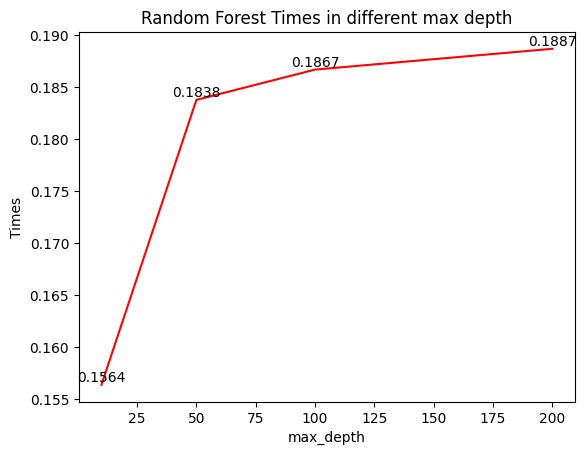

In [ ]:
plt.plot([p for p in param_grid['max_depth']], times, color='r')
plt.ylabel("Times")
plt.xlabel("max_depth")
plt.title("Random Forest Times in different max depth")

for i, acc in enumerate(times):
    plt.text([p for p in param_grid['max_depth']][i], acc, f'{acc:.4f}', ha='center', va='bottom')

plt.show()

In [ ]:
param_grid = {
    'n_estimators': [200],
    'max_depth': [50],
    'criterion': ['gini', 'entropy', 'log_loss'],
}

test_accuracy, times = run(param_grid)

[1|3] n_estimators=200, max_depth=50, criterion=gini accuracy=0.8442
[2|3] n_estimators=200, max_depth=50, criterion=entropy accuracy=0.8479
[3|3] n_estimators=200, max_depth=50, criterion=log_loss accuracy=0.8479
n_estimators=200, max_depth=50, criterion=entropy, best_accuracy=0.8479


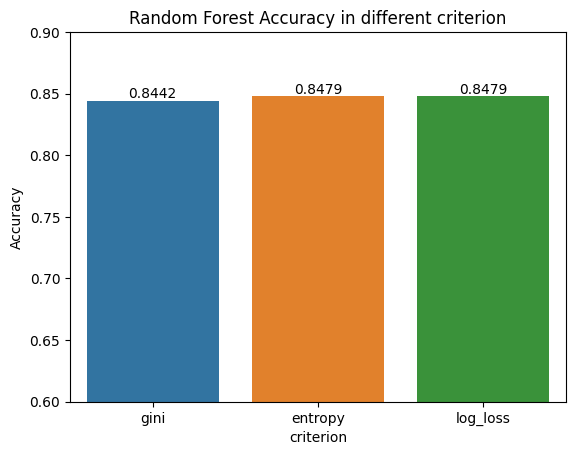

In [ ]:
sns.barplot(x=[p for p in param_grid['criterion']], y=test_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("criterion")
plt.title("Random Forest Accuracy in different criterion")
plt.ylim(0.6, 0.9)
for i, v in enumerate(test_accuracy):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.show()

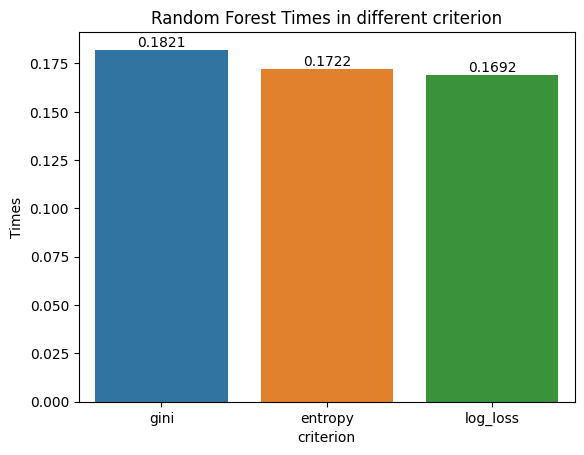

In [ ]:
sns.barplot(x=[p for p in param_grid['criterion']], y=times)
plt.ylabel("Times")
plt.xlabel("criterion")
plt.title("Random Forest Times in different criterion")
for i, v in enumerate(times):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.show()

# Final Models

## Model 1 - Fully Connected Neural Network

In [ ]:
from sklearn.metrics import f1_score

def create_model(mlp=[128, 128], activation='relu'):
    """
      mlp: model depths of hidden layers
    """
    layers = [keras.Input(shape=(28, 28, 3)), keras.layers.Flatten()]
    for i, units in enumerate(mlp):
        layers.append(
            keras.layers.Dense(units=units, activation=activation)
        )
    layers.append(keras.layers.Dropout(0.5))
    layers.append(keras.layers.Dense(8, activation="softmax"))

    model = keras.Sequential(layers)
    return model

model = create_model(mlp=[128, 128])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_checkpoint = ModelCheckpoint("/content/temp.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)

history = model.fit(
    normalized_X,
    y,
    epochs=15,
    validation_data=(normalized_X_val, y_val),
    callbacks=[model_checkpoint],
    verbose=0
)

best_model = load_model("/content/temp.h5")
start = time.time()
_, accuracy = best_model.evaluate((X_test/255.-mean)/std, y_test)
end = time.time()
print(f'Test accuracy: {accuracy:.4f}, runtime: {end - start: .4f}')

y_pred = best_model.predict((X_test/255.-mean)/std)
y_pred_labels = np.argmax(y_pred, axis=1)
macro_f1 = f1_score(y_test, y_pred_labels, average='macro')
print(f'Macro F1 score: {macro_f1:.4f}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 0s 2ms/step - loss: 0.4515 - accuracy: 0.8488
Test accuracy: 0.8488, runtime:  0.4847
107/107 [==============================] - 0s 2ms/step
Macro F1 score: 0.8283


## Model 2 - Convolutional Neural Network

In [ ]:
def create_model(depths=[[32, 32, 32], [64, 64, 64], [128, 128, 128]], kernel_size=3, strides=1, activation='relu'):
    """
      mlp: model depths of hidden layers
    """
    layers = [keras.Input(shape=(28, 28, 3))]
    for dep_units in depths:
        for channel in dep_units:
            layers.append(keras.layers.Conv2D(channel, kernel_size=(kernel_size, kernel_size),
                                              strides=(strides, strides), activation=activation, padding='same'))
        layers.append(keras.layers.AvgPool2D(pool_size=(2, 2)))
    layers += [
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(8, activation="softmax"),
    ]
    model = keras.Sequential(layers)
    return model

model = create_model(depths=[[128, 128, 128], [128*2, 128*2, 128*2]], activation='leaky_relu')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_checkpoint = ModelCheckpoint("/content/temp.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)

history = model.fit(
    my_generator(X255,y,batch_size=256),
    steps_per_epoch=len(X255) // 256,
    epochs=30,
    validation_data=(normalized_X255_val, y_val),
    callbacks=[model_checkpoint],
    verbose=0
)

best_model = load_model("/content/temp.h5")
start = time.time()
_, accuracy = best_model.evaluate((X_test-mean255)/std255, y_test)
end = time.time()
print(f'Test accuracy: {accuracy:.4f}, runtime: {end - start: .4f}')

y_pred = best_model.predict((X_test-mean255)/std255)
y_pred_labels = np.argmax(y_pred, axis=1)
macro_f1 = f1_score(y_test, y_pred_labels, average='macro')
print(f'Macro F1 score: {macro_f1:.4f}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 1s 8ms/step - loss: 0.1735 - accuracy: 0.9491
Test accuracy: 0.9491, runtime:  1.5787
107/107 [==============================] - 1s 6ms/step
Macro F1 score: 0.9408


## Model 3 - PCA+SVM

In [ ]:
pca = PCA(n_components=400, random_state=42)
svc = SVC(C=1, kernel='rbf', random_state=42)
model = Pipeline([
    ('pca', pca),
    ('svc', svc),
])
model.fit(X.reshape(X.shape[0], -1), y)
data = X_test.reshape(X_test.shape[0], -1)/255.
start = time.time()
y_pred = model.predict(data)
end = time.time()
accuracy = accuracy_score(y_test, y_pred)
print(f"test accuracy = {accuracy:.4f}, runtime: {end - start: .4f}")

macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1 score: {macro_f1:.4f}")

test accuracy = 0.8663, runtime:  8.9472
Macro F1 score: 0.8431


## Model 4 - Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators=200,
                                max_depth=50,
                                criterion='entropy',
                                random_state=42)

model.fit(normalized_X.reshape(normalized_X.shape[0], -1), y)
data = ((X_test/255. - mean) / std).reshape(X_test.shape[0],-1)
start = time.time()
y_pred = model.predict(data)
end = time.time()
accuracy = accuracy_score(y_test, y_pred)
print(f"test accuracy = {accuracy:.4f}, runtime: {end - start: .4f}")

macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1 score: {macro_f1:.4f}")

test accuracy = 0.8321, runtime:  0.2336
Macro F1 score: 0.7997
